# Grid World迷宮之策略循環(Policy Iteration)

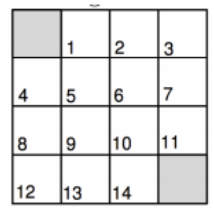

In [1]:
# 從IPython.display模組匯入Image類別，用來在Jupyter Notebook中顯示圖片
from IPython.display import Image

# 載入並顯示位於當前目錄中的grid_world.png圖片
Image('./grid_world.png')

In [2]:
# 匯入zipfile模組，用來處理.zip壓縮檔案
import zipfile

# 使用with敘述開啟lib.zip壓縮檔案，確保使用完自動關閉
with zipfile.ZipFile("lib.zip") as zf:
    # 使用infolist()取得壓縮檔中所有檔案的資訊(ZipInfo物件)
    for info in zf.infolist():
    
        # 因為某些zip壓縮檔的檔名是以cp437編碼(特別是從Windows系統壓縮的)
        # 所以這裡先將原本的檔名(字串)用cp437編碼為bytes，再用utf-8解碼為正確的字串
        # 這樣可以正確顯示中文或特殊字元的檔名
        print(info.filename.encode('cp437').decode('utf-8'))

        # 將目前這個檔案(info)解壓縮到target_folder資料夾中
        zf.extract(info, "target_folder")

lib/__init__.py
lib/__pycache__/
lib/__pycache__/__init__.cpython-38.pyc
lib/__pycache__/__init__.cpython-39.pyc
lib/__pycache__/plotting.cpython-38.pyc
lib/__pycache__/plotting.cpython-39.pyc
lib/atari/
lib/atari/__init__.py
lib/atari/helpers.py
lib/atari/state_processor.py
lib/envs/
lib/envs/.ipynb_checkpoints/
lib/envs/.ipynb_checkpoints/gridworld-checkpoint.py
lib/envs/__init__.py
lib/envs/__pycache__/
lib/envs/__pycache__/__init__.cpython-36.pyc
lib/envs/__pycache__/__init__.cpython-38.pyc
lib/envs/__pycache__/__init__.cpython-39.pyc
lib/envs/__pycache__/blackjack.cpython-38.pyc
lib/envs/__pycache__/blackjack.cpython-39.pyc
lib/envs/__pycache__/cliff_walking.cpython-36.pyc
lib/envs/__pycache__/cliff_walking.cpython-38.pyc
lib/envs/__pycache__/cliff_walking.cpython-39.pyc
lib/envs/__pycache__/discrete.cpython-38.pyc
lib/envs/__pycache__/discrete.cpython-39.pyc
lib/envs/__pycache__/gridworld.cpython-38.pyc
lib/envs/__pycache__/gridworld.cpython-39.pyc
lib/envs/__pycache__/gridworld0

In [3]:
# 匯入numpy套件，用於數值計算與陣列處理
import numpy as np

# 從lib.envs.gridworld模組中匯入自訂的GridworldEnv類別
# 這代表有一個自定義的「網格世界」強化學習環境，位於專案的lib/envs/gridworld.py檔案中
from lib.envs.gridworld import GridworldEnv

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [4]:
# 修正np.bool已被移除的問題(NumPy1.20+不再支援np.bool)
# 如果當前NumPy沒有np.bool屬性(新版會移除)
if not hasattr(np, 'bool'):
    # 則將np.bool指定為內建的bool，等效於舊版的np.bool行為
    np.bool = bool  # 等價替代，讓使用np.bool的舊程式碼能正常執行

C:\Users\hankc\AppData\Local\Temp\ipykernel_11212\585787934.py:3: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):


In [5]:
# 建立一個GridWorld強化學習環境實例
env = GridworldEnv()

# 動作對應的數值編碼(Action Encoding)：
# 在強化學習環境中，每個數字代表智能體(Agent)的一個移動方向

# UP = 0     # 向上移動，代表智能體往上方的格子前進
# RIGHT = 1  # 向右移動，代表智能體往右方的格子前進
# DOWN = 2   # 向下移動，代表智能體往下方的格子前進
# LEFT = 3   # 向左移動，代表智能體往左方的格子前進

c:\Users\hankc\anaconda3\Lib\site-packages\gym\utils\seeding.py:41: DeprecationWarning: WARN: Function `rng.rand(*size)` is marked as deprecated and will be removed in the future. Please use `Generator.random(size)` instead.
  deprecation(


## 策略評估函數

In [6]:
# 定義一個策略評估(Policy Evaluation)函式
# 用來在給定策略下，計算每個狀態的狀態價值(Value Function V)
# 此版本會根據設定的收斂門檻theta自動停止
def policy_eval(policy, env, discount_factor = 1.0, theta = 0.00001):

    # 初始化狀態值函數V為全0，大小等於環境的狀態數env.nS
    V = np.zeros(env.nS)

    # 建立一個V的複製版本，用來暫存每次更新後的值
    V1 = np.copy(V)

    # 持續迭代直到狀態值函數的變化小於設定的門檻theta
    while True:
        # 每次迭代開始時，將最大差異(delta)初始化為0
        delta = 0

        # 遍歷每一個狀態s
        for s in range(env.nS):
            # 用來暫存狀態s的新價值
            v = 0

            # 遍歷所有動作a及其在該狀態下的選擇機率action_prob
            for a, action_prob in enumerate(policy[s]):
                # 遍歷在狀態s執行動作a的所有可能轉移(由環境模型env.P提供)
                for prob, next_state, reward, done in env.P[s][a]:
                    # 套用貝爾曼期望方程式計算狀態價值：
                    # v += 該動作機率 × 轉移機率 × [即時獎勵 + 折扣後的下一狀態價值]
                    v += action_prob * prob * (reward + discount_factor * V[next_state])

            # 更新最大差異(delta)，用來檢查是否收斂
            delta = max(delta, np.abs(v - V[s]))

            # 將計算得到的v更新到對應狀態的暫存V1中
            V1[s] = v

        # 將更新完的V1複製回V，準備下一次迭代
        V = np.copy(V1)

        # 若最大變動量(delta)小於門檻theta，表示已收斂，停止迴圈
        if delta < theta:
            break

    # 所有迭代完成後，傳回狀態值函數V的最終結果
    return np.array(V)

## 策略改善函數

In [7]:
# 定義一個策略改進(Policy Improvement)函式
# 用來不斷優化給定的初始策略，直到找到最穩定的最優策略
# 此函式會搭配策略評估函式(policy_eval_fn)來進行策略疊代
def policy_improvement(env, policy_eval_fn = policy_eval, discount_factor = 1.0, max_iterations = 100, theta = 0.1):

    # 定義一個一步前瞻(one-step lookahead)函式
    # 計算給定狀態s下，每個行動a對應的行動值(Action-Value)
    def one_step_lookahead(state, V):
        # 初始化每個動作的價值為0
        A = np.zeros(env.nA)

        # 遍歷所有動作a
        for a in range(env.nA):
            # 根據環境模型，計算該動作a的期望回報
            for prob, next_state, reward, done in env.P[state][a]:
                # 行動值Q(s, a) = Σ[P(s'|s, a) * (r + γ * V(s'))]
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A

    # 初始化策略為均勻隨機策略：每個狀態均勻選擇所有動作
    policy = np.ones([env.nS, env.nA]) / env.nA

    # 不斷進行策略改進，直到策略收斂為止或超過最大迭代次數
    for _ in range(max_iterations):
        # 進行策略評估：計算在當前策略下每個狀態的狀態價值函數V
        V = policy_eval_fn(policy, env, discount_factor, theta)

        # 設定策略穩定標誌為True(若發現更好的策略會設為False)
        policy_stable = True

        # 遍歷每一個狀態
        for s in range(env.nS):
            # 記錄當前策略在該狀態下選擇的行動
            chosen_a = np.argmax(policy[s])

            # 計算該狀態下，每個可能動作的行動值
            action_values = one_step_lookahead(s, V)

            # 選擇價值最大的動作(即貪婪策略)
            best_a = np.argmax(action_values)

            # 若新的最佳動作與原策略不同，則策略不穩定
            if chosen_a != best_a:
                policy_stable = False

            # 更新策略：只保留最佳動作(其他機率為0)
            policy[s] = np.eye(env.nA)[best_a]

        # 若策略穩定(沒有任何狀態的策略發生變動)，則結束迴圈並傳回結果
        if policy_stable:
            break

    # 傳回最優策略與最終的狀態值函數
    return policy, V

In [8]:
# 執行策略循環(Policy Iteration)演算法
# 呼叫前面定義的policy_improvement函式，傳入環境env
# 傳回最終的最優策略policy以及對應的狀態價值函數v
policy, v = policy_improvement(env)

In [9]:
# 顯示最終策略的機率分配(每個狀態對每個動作的選擇機率)
print("策略機率分配:")
print(policy)
print("\n")

# 顯示每個狀態下選擇機率最高的動作(即最優策略)
# 將一維動作索引轉成4x4矩陣的形式(對應FrozenLake的地圖)
# 動作代號：0 = ↑(up), 1 = →(right), 2 = ↓(down), 3 = ←(left)

print("4x4 策略機率分配(0 = up, 1 = right, 2 = down, 3 = left):")
print(np.reshape(np.argmax(policy, axis = 1), env.shape))
print("\n")

# 顯示最終狀態值函數(每個格子狀態的預期累積報酬)
# 將一維的狀態值向量v轉成4x4矩陣的形式以對應地圖視覺結構
print("4x4 狀態值函數:")
print(v.reshape(env.shape))
print("\n")

策略機率分配:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


4x4 策略機率分配(0 = up, 1 = right, 2 = down, 3 = left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]


4x4 狀態值函數:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]




In [10]:
# 驗證計算出的狀態值函數v是否與預期結果expected_v接近(小數點後2位)
expected_v = np.array([0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1, 0])
np.testing.assert_array_almost_equal(v, expected_v, decimal = 2)

## Windy Grid World 迷宮測試

In [11]:
# 匯入不同的強化學習環境模組(需事先安裝或從OpenAI Gym擴充)
from lib.envs.windy_gridworld import WindyGridworldEnv  # 風之格子世界
from lib.envs.cliff_walking import CliffWalkingEnv      # 懸崖走路環境
from lib.envs.gridworld import GridworldEnv             # 基本格子世界環境

# 初始化環境：這裡使用的是CliffWalking(懸崖走路)環境
# 起點在左下角，終點在右下角，中間的懸崖會導致掉落並受到負獎勵
env = CliffWalkingEnv()

In [12]:
# 查看GridWorld環境的轉移模型P
# P是一個嵌套字典，描述在每個狀態執行某個動作後，可能轉移到哪些狀態、機率是多少、是否結束等資訊
# 用於實作動態規劃演算法，如：策略評估、策略改進、值迭代、策略迭代等
env.P

{0: {0: [(1.0, 0, -1.0, False)],
  1: [(1.0, 1, -1.0, False)],
  2: [(1.0, 12, -1.0, False)],
  3: [(1.0, 0, -1.0, False)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 13, -1.0, False)],
  3: [(1.0, 0, -1.0, False)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 14, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 4, -1.0, False)],
  2: [(1.0, 15, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 4, -1.0, False)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 16, -1.0, False)],
  3: [(1.0, 3, -1.0, False)]},
 5: {0: [(1.0, 5, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 17, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 6, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 18, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 7, -1.0, False)],
  1: [(1.0, 8, -1.0, False)],
  2: [(1.0, 19, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},


In [13]:
# 隨機策略，機率均等：在每個狀態下，對每個動作(action)賦予相同的機率
# np.ones([env.nS, env.nA])創建一個大小為[狀態數量, 動作數量]的矩陣，並將所有值設為1
# 然後除以動作數量(env.nA)，使得每個動作的機率均等
random_policy = np.ones([env.nS, env.nA]) / env.nA

# 評估隨機策略：計算該隨機策略下每個狀態的狀態價值函數(V)
# theta = 22是收斂條件，設定最大變動量的容忍誤差(這裡設定為22較大，可以根據需要調整)
v = policy_eval(random_policy, env, theta = 22)

# 輸出狀態值函數：顯示該隨機策略下的狀態價值函數(V)
# 假設環境的狀態空間是6x8的網格，使用v.reshape()方法將一維向量轉為6x8的格狀顯示方式
print("狀態值函數:")
print(v.reshape((6, 8)))

狀態值函數:
[[ -722.51615437  -744.75221796  -776.81661995  -807.75063697
   -830.96046916  -843.19413687  -843.19413687  -830.96046916]
 [ -807.75063697  -776.81661995  -744.75221796  -722.51615437
   -781.4158988   -816.39931357  -860.01078979  -898.21777004]
 [ -925.26784418  -939.09855251  -939.09855251  -925.26784418
   -898.21777004  -860.01078979  -816.39931357  -781.4158988 ]
 [ -886.52414133  -960.9501504  -1030.72960917 -1082.6416538
  -1116.18269185 -1132.56158456 -1132.56158456 -1116.18269185]
 [-1082.6416538  -1030.72960917  -960.9501504   -886.52414133
   -998.47773191 -1092.75878447 -1202.5160867  -1269.31647918]
 [-1308.72852841 -1327.21215404 -1327.21215404 -1308.72852841
  -1269.31647918 -1202.5160867  -1092.75878447  -998.47773191]]


In [14]:
# 顯示最終策略的機率分配(每個狀態對每個動作的選擇機率)
print("策略機率分配:")
print(policy)
print("")

# 輸出狀態值函數：顯示該隨機策略下的狀態價值函數(V)
# 假設環境的狀態空間是6x8的網格，使用v.reshape()方法將一維向量轉為6x8的格狀顯示方式
print("狀態值函數:")
print(v.reshape((6, 8)))

策略機率分配:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

狀態值函數:
[[ -722.51615437  -744.75221796  -776.81661995  -807.75063697
   -830.96046916  -843.19413687  -843.19413687  -830.96046916]
 [ -807.75063697  -776.81661995  -744.75221796  -722.51615437
   -781.4158988   -816.39931357  -860.01078979  -898.21777004]
 [ -925.26784418  -939.09855251  -939.09855251  -925.26784418
   -898.21777004  -860.01078979  -816.39931357  -781.4158988 ]
 [ -886.52414133  -960.9501504  -1030.72960917 -1082.6416538
  -1116.18269185 -1132.56158456 -1132.56158456 -1116.18269185]
 [-1082.6416538  -1030.72960917  -960.9501504   -886.52414133
   -998.47773191 -1092.75878447 -1202.5160867  -1269.31647918]
 [-1308.72852841 -1327.21215404 -1327.21215404 -1308.72852841
  -1269.31647918 -1202.5160867  -1092.75878447  -998.4777